In [1]:
#!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)


In [7]:
import os #to easier navigate in files
import time #keep tracking on movements
import uuid #create uniform uniqe identifier for images
import cv2

In [6]:
IMAGE_PATH = os.path.join('data', 'images')
number_of_images = 30

In [11]:
# capture = cv2.VideoCapture(0) #stablish connection to the camera, the camera number may be different depends in the device
# for image in range(number_of_images):#iterate trough images
#     print(f'Collecting image {image}') #print each image in images
#     return_value, frame = capture.read() #read from capture device that did it even capture something and the frames
#     image_name = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg') #define the name of the file of the image with unique name
#     cv2.imwrite(image_name, frame) #save the frame into the file
#     cv2.imshow('frame', frame) #display it
#     time.sleep(1) #apply delay

#     #easly breake the loop by press q
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# capture.release()
# cv2.destroyAllWindows()

In [12]:
!labelme #open label me and labeling face on the images 

fish: Unknown command: labelme
fish: 
labelme #open label me
^~~~~~^


In [50]:
#!pipenv install matplotlib numpy
import tensorflow as tf
import numpy as np #to data preproccessing
import cv2
import json
from matplotlib import pyplot as plt #to visualize images

2024-02-02 21:56:52.469585: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 21:56:52.705972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 21:56:52.706051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 21:56:52.743685: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 21:56:52.823884: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 21:56:52.824797: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [9]:
#limit gpu memory growth to avoid OutOfMemory error by setting GPU Memory Cons Growth and check GPU availablity
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("GPUs are available.")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPUs are not available.TensorFlow will automatically use the CPU.")

GPUs are not available.TensorFlow will automatically use the CPU.


In [22]:
#load image to tensorflow data pipeline
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)
#load image
def load_image(file_path):
    byte_encoded_image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(byte_encoded_image)
    return image

In [23]:
images = images.map(load_image) #apply load_image func to each element of dataset(images)
images.as_numpy_iterator().next()
type(images) # check that is tensorflow data pipeline
image_generator = images.batch(4).as_numpy_iterator() 


In [31]:
plot_image = image_generator.next()

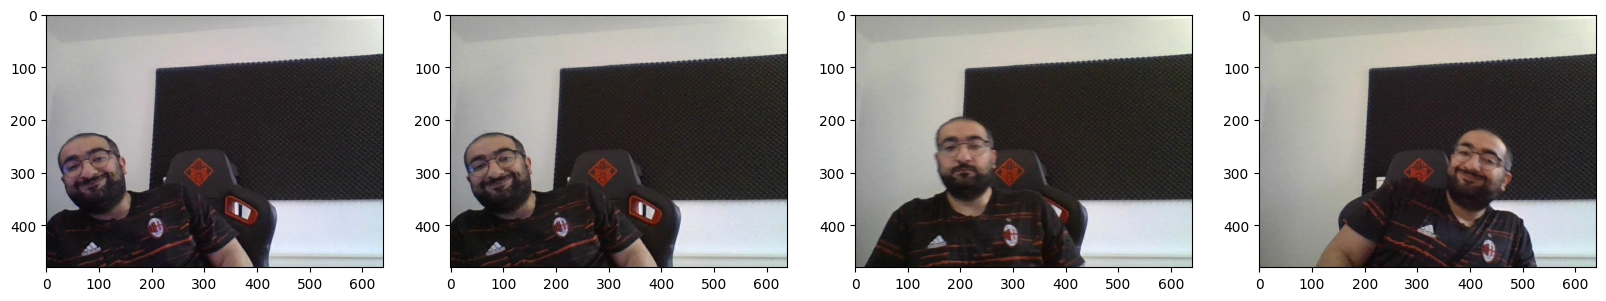

In [32]:
fig, ax =plt.subplots(ncols=4, figsize = (20, 20))
for idx , image in enumerate(plot_image):
    ax[idx].imshow(image)
plt.show()

apply 70% of the images to training
apply 15% of the rest to test and val (each)

In [41]:
#moving labels to corresponded image dir
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [48]:
#check width and height of the images, that we not exceed the actual size while cropping
from pathlib import Path
import random
selected_img_path = random.choice(list(Path('data/train/images').glob('*.jpg')))
img = cv2.imread(str(selected_img_path))
#print(selected_img_path)
img.shape

data/train/images/e83277b4-c1c5-11ee-a8c0-983b8fb7861c.jpg


(480, 640, 3)

In [34]:
import albumentations as alb

In [35]:
# create an augmentation pipeline
augmentor = alb.Compose([alb.RandomCrop(width = 450, height = 450),
                         alb.HorizontalFlip(p = 0.5),
                         alb.RandomBrightnessContrast(p = 0.2),
                         alb.RandomGamma(p = 0.2),
                         alb.RGBShift(p = 0.2),
                         alb.VerticalFlip(p = 0.5)],
                         bbox_params = alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [62]:
img = cv2.imread(os.path.join(selected_img_path))
selected_annotation_path = selected_img_path.stem + '.json'
#print(selected_annotation_path)
with open(os.path.join('data', 'train', 'labels', selected_annotation_path ), 'r') as f:
           label = json.load(f)

#get the points from dict label
label['shapes'][0]['points']

[[165.1282051282051, 153.07692307692307],
 [364.1025641025641, 431.53846153846155]]